In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
from lmfit import Parameters, minimize, report_fit
import requests

In [22]:
r = requests.get('https://api.covid19api.com/dayone/country/morocco')
res=r.json()
df=pd.DataFrame(res)
c=df['Confirmed']
a=df['Active']
r=df['Recovered']
d=df['Deaths']
df

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date
0,Morocco,MA,,,,31.79,-7.09,1,0,0,1,2020-03-02T00:00:00Z
1,Morocco,MA,,,,31.79,-7.09,1,0,0,1,2020-03-03T00:00:00Z
2,Morocco,MA,,,,31.79,-7.09,1,0,0,1,2020-03-04T00:00:00Z
3,Morocco,MA,,,,31.79,-7.09,2,0,0,2,2020-03-05T00:00:00Z
4,Morocco,MA,,,,31.79,-7.09,2,0,0,2,2020-03-06T00:00:00Z
...,...,...,...,...,...,...,...,...,...,...,...,...
87,Morocco,MA,,,,31.79,-7.09,7643,202,5195,2246,2020-05-28T00:00:00Z
88,Morocco,MA,,,,31.79,-7.09,7714,202,5271,2241,2020-05-29T00:00:00Z
89,Morocco,MA,,,,31.79,-7.09,7780,204,5401,2175,2020-05-30T00:00:00Z
90,Morocco,MA,,,,31.79,-7.09,7807,205,5459,2143,2020-05-31T00:00:00Z


In [34]:
# SIRD Model
## Input:
### y: valeur actuel de S I R et D
### t: L'instant temps
### N: Population total
### beta:
### gamma: 
### sigma:
## Output
### la variation de S I R et D

def deriv(y, x, N, beta, gamma, sigma):
    S, I, R , D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I- sigma * I
    dRdt = gamma * I
    dDdt = sigma * I
    return dSdt, dIdt, dRdt , dDdt

#Test de la fonction deriv
N=1e4
deriv([10, 1, 0, 0],1,N, 1, 0.2, 0.1)


(-0.001, -0.29900000000000004, 0.2, 0.1)

In [30]:
#Integration du model sur tous les points x=[x1,....,xn] avec condition initial y0
#y0 = S0, I0, R0, D0
#S0 = N - I0 - R0 - D0
def f(params,x,y0):
    N= params["N"]
    # Integrate the SIR equations over the time grid, t.
    beta= params["beta"].value
    gamma= params["gamma"].value
    sigma= params["sigma"].value
    return odeint(deriv, y0, x, args=(N,beta, gamma, sigma)).T

N: 10000.0


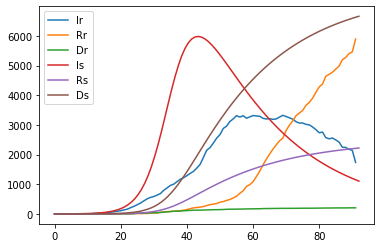

In [42]:
fit_params = Parameters()
fit_params.add('N', value=N,vary=False)
fit_params.add('beta', value=0.3, min=0, max=4.0)
fit_params.add('gamma', value=0.01, min=0, max=1.0)
fit_params.add('sigma', value=0.03, min=0, max=1.0)

N=fit_params['N'].value
print('N:',N)

#Test de f
x=np.linspace(0,92,92)
y=f(fit_params,x,[N-1,1,0,0])
data=np.array([a,r,d])

plt.plot(data[0], label="Ir")
plt.plot(data[1],label="Rr")
plt.plot(data[2],label="Dr")

plt.plot(x,y[1], label="Is")
plt.plot(x,y[2],label="Rs")
plt.plot(x,y[3],label="Ds")

plt.legend()


In [50]:
def objective(params,f,x,data,y0):
    # Initial number of infected and recovered individuals, I0 and R0.
    ndata, _ = data.shape
    resid = 0.0*data[:]
    ret=f(params,x,y0)
    for i in range(ndata-1):
        resid[i, :] = data[i, :] - ret[i+1,:]
    return resid.flatten()

[[Variables]]
    N:      10000 (fixed)
    beta:   3.99999813 +/- 0.01989925 (0.50%) (init = 0.3)
    gamma:  0.00342160 +/- 0.00259470 (75.83%) (init = 0.01)
    sigma:  0.99999999 +/- 0.03074653 (3.07%) (init = 0.03)


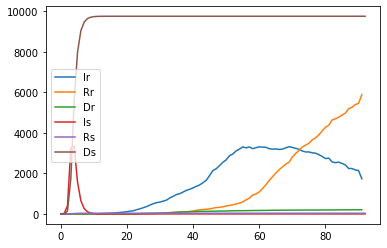

In [51]:
y0=[1e6,1,0,0]
out = minimize(objective, fit_params, args=(f,x,data,y0))
out
report_fit(out.params)
x=np.linspace(0,92,92)
y=f(out.params,x,[N-1,1,0,0])
data=np.array([a,r,d])

plt.plot(data[0], label="Ir")
plt.plot(data[1],label="Rr")
plt.plot(data[2],label="Dr")

plt.plot(x,y[1], label="Is")
plt.plot(x,y[2],label="Rs")
plt.plot(x,y[3],label="Ds")

plt.legend()
